<div id="Data" class="section level1">
<h1><span class="header-section-number">Chapter 4</span> Data preprocessing</h1>
<p>The methods we describe in this chapter are driven by financial applications. For an introduction to non-financial data processing, we recommend two references: chapter 3 from the general purpose ML book by <span class="citation">Boehmke and Greenwell (<a href="#ref-boehmke2019hands">2019</a>)</span> and the monograph on this dedicated subject by <span class="citation">Kuhn and Johnson (<a href="#ref-kuhn2019feature">2019</a>)</span>.</p>
<div id="know-your-data" class="section level2">
<h2><span class="header-section-number">4.1</span> Know your data</h2>
<p>The first step, as in any quantitative study, is obviously to make sure the data is trustworthy, i.e., comes from a reliable provider (a minima). The landscape in financial data provision is vast to say the least: some providers are well established (e.g., Bloomberg, Thomson-Reuters, Datastream, CRSP, Morningstar), some are more recent (e.g., Capital IQ, Ravenpack) and some focus on alternative data niches (see <a href="https://alternativedata.org/data-providers/" class="uri">https://alternativedata.org/data-providers/</a> for an exhaustive list). Unfortunately, and to the best of our knowledge, no study has been published that evaluates a large spectrum of these providers in terms of data reliability.</p>
<p>The second step is to have a look at <strong>summary statistics</strong>: ranges (minimum and maximum values), and averages and medians. Histograms or plots of time series carry of course more information but cannot be analyzed properly in high dimensions. They are nonetheless sometimes useful to track local patterns or errors for a given stock and/or a particular feature.
Beyond first order moments, second order quantities (variances and covariances/correlations) also matter because they help spot colinearities. When two features are highly correlated, problems may arise in some models (e.g., simple regressions, see Section <a href="unsup.html#corpred">15.1</a>).</p>
<p>Often, the number of predictors is so large that it is unpractical to look at these simple metrics. A minimal verification is recommended. To further ease the analysis:</p>
<ul>
<li>focus on a subset of predictors, e.g., the ones linked to the most common factors (market-capitalization, price-to-book or book-to-market, momentum (past returns), profitability, asset growth, volatility);<br />
</li>
<li>track outliers in the summary statistics (when the maximum/median or median/minimum ratios seem suspicious).</li>
</ul>
<p>Below, in Figure <a href="Data.html#fig:boxcorr">4.1</a>, we show a box plot that illustrates the distribution of correlations between features and the one month ahead return. The correlations are computed on a date-by-date basis, over the whole cross-section of stocks. They are mostly located close to zero, but some dates seem to experience extreme shifts (outliers are shown with black circles). The market capitalization has the median which is the most negative while volatility is the only predictor with positive median correlation (this particular example seems to refute the low risk anomaly).</p>

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
from IPython.core import display as ICD
os.chdir('..')
from utils.data_utils import load_data_ml, load_ff_factors
os.chdir('notebooks')
plt.rcParams['figure.figsize'] = (15, 9)
warnings.filterwarnings('ignore')

data_ml = load_data_ml()

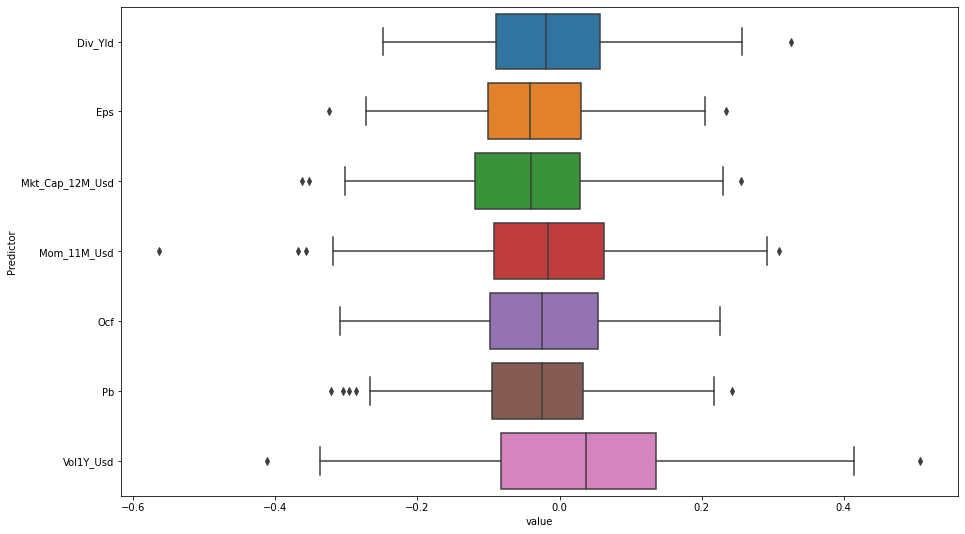

In [2]:
features_short = ['Div_Yld', 'Eps', 'Mkt_Cap_12M_Usd', 'Mom_11M_Usd', 'Ocf', 'Pb', 'Vol1Y_Usd']
corrs = data_ml[features_short + ['R1M_Usd', 'date']].groupby('date').apply(
    lambda x: pd.Series(np.corrcoef(x[feature], x['R1M_Usd'])[0, 1] for feature in features_short)
)
corrs.columns = features_short
corrs['date'] = corrs.index
corrs = pd.melt(  # Put in tidy format
    corrs,
    id_vars='date',
    var_name='Predictor'
)

sns.boxplot(x=corrs['value'], y=corrs['Predictor'])
plt.show()

<p class="caption">
    <center>FIGURE 4.1: Boxplot of correlations with the 1M forward return (label).</center>
</p>
</div>

<p>More importantly, when seeking to work with supervised learning (as we will do most of the time), the link of some features with the dependent variable can be further characterized by the smoothed <strong>conditional average</strong> because it shows how the features impact the label. The use of the conditional average has a deep theoretical grounding. Suppose there is only one feature <span class="math inline">\(X\)</span> and that we seek a model <span class="math inline">\(Y=f(X)+\text{error}\)</span>, where variables are real-valued. The function <span class="math inline">\(f\)</span> that minimizes the average squared error <span class="math inline">\(\mathbb{E}[(Y-f(X))^2]\)</span> is the so-called regression function (see Section 2.4 in <span class="citation">Hastie, Tibshirani, and Friedman (<a href="#ref-friedman2009elements">2009</a>)</span>):
<span class="math display" id="eq:regfun">\[\begin{equation}
\tag{4.1}
f(x)=\mathbb{E}[Y|X=x].
\end{equation}\]</span></p>
<p>In Figure <a href="Data.html#fig:regfun">4.2</a>, we plot two illustrations of this function when the dependent variable (<span class="math inline">\(Y\)</span>) is the one month ahead return. The first one pertains to the average market capitalization over the past year and the second to the volatility over the past year as well. Both predictors have been uniformized (see Section <a href="Data.html#scaling">4.4.2</a> below) so that their values are uniformly distributed in the cross-section of assets for any given time period. Thus, the range of features is <span class="math inline">\([0,1]\)</span> and is shown on the <span class="math inline">\(x\)</span>-axis of the plot. The grey corridors around the lines show 95% level confidence interval for the computation of the mean. Essentially, it is narrow when both (i) many data points are available and (ii) these points are not too dispersed.</p>

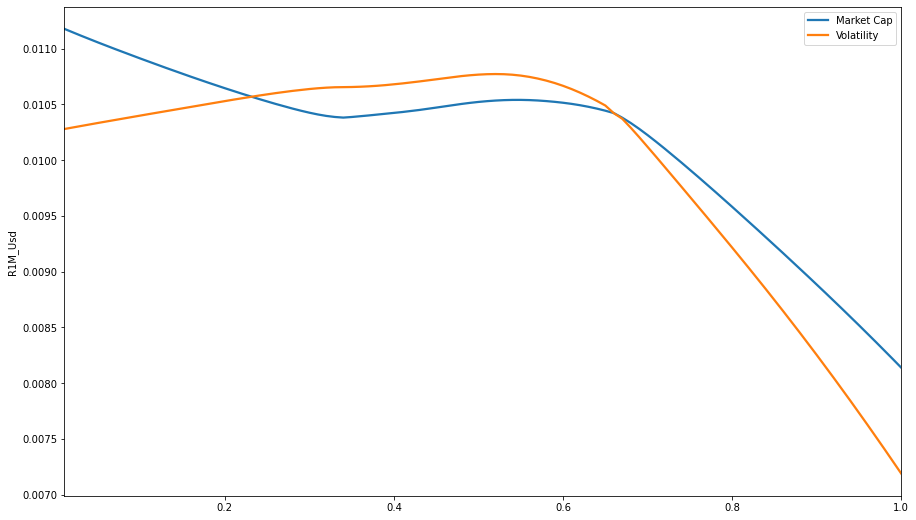

In [3]:
fig, ax = plt.subplots(1)
sns.regplot(
    x=data_ml['Mkt_Cap_12M_Usd'],
    y=data_ml['R1M_Usd'],
    scatter=False,
    lowess=True,
    label='Market Cap',
    ax=ax
)
sns.regplot(
    x=data_ml['Vol1Y_Usd'],
    y=data_ml['R1M_Usd'],
    scatter=False,
    lowess=True,
    label='Volatility',
    ax=ax
)
ax.set_xlabel('')
plt.legend()
plt.show()

<p class="caption">
<center>FIGURE 4.2: Conditional expectations: average returns as smooth functions of features.</center>
</p>
</div>

<p>The two variables have a close to monotonic impact on future returns. Returns, on average, decrease with market capitalization (thereby corroborating the so-called <em>size</em> effect). The reverse pattern is less pronounced for volatility: the curve is rather flat for the first half of volatility scores and progressively increases, especially over the last quintile of volatility values (thereby contradicting the low-volatility anomaly).</p>
<p>One important empirical property of features is <strong>autocorrelation</strong> (or absence thereof). A high level of autocorrelation for one predictor makes it plausible to use simple imputation techniques when some data points are missing. But autocorrelation is also important when moving towards prediction tasks and we discuss this issue shortly below in Section <a href="Data.html#pers">4.6</a>. In Figure <a href="Data.html#fig:histcorr">4.3</a>, we build the histogram of autocorrelations, computed stock-by-stock and feature-by-feature.</p>

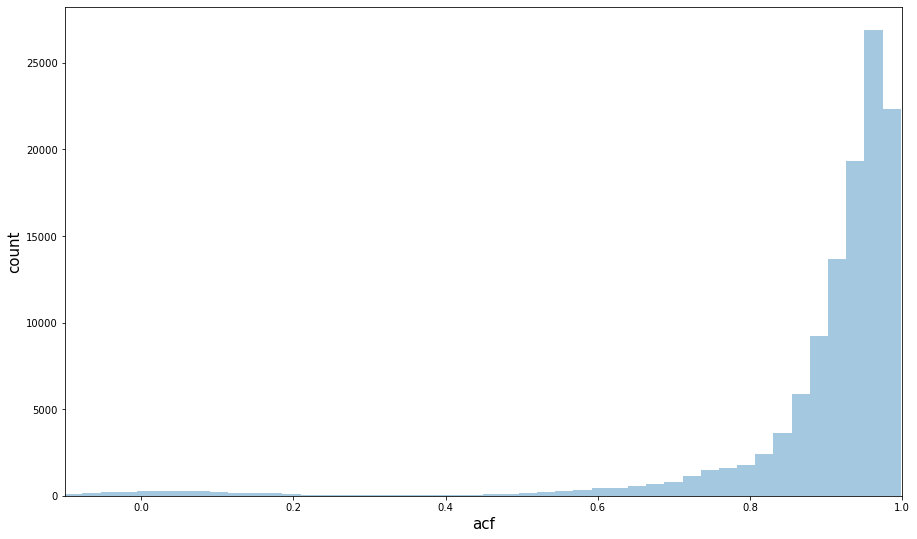

In [4]:
import statsmodels.tsa.stattools as smt

autocorrs = pd.melt(  # From dataset:
    data_ml,
    id_vars=['date', 'stock_id'],  # Keep ids
    value_vars=data_ml.columns[2:],  # Keep features
    var_name='feature'
).groupby(['stock_id', 'feature'])['value'].apply(lambda x: smt.acf(x, nlags=1)[-1])  # Group and compute acf

ax = sns.distplot(autocorrs, bins=60, kde=False)
ax.set_ylabel('count', fontsize=15)
ax.set_xlabel('acf', fontsize=15)
ax.set_xlim(-.1, 1)
plt.show()

<p class="caption">
<center>FIGURE 4.3: Histogram of sample feature autocorrelations.</center>
</p>
</div>

<p>Given the large number of values to evaluate, the above chunk is quite time-consuming. The output shows that predictors are highly autocorrelated: most of them have a first order autocorrelation above 0.80.</p>
</div>
<div id="missing-data" class="section level2">
<h2><span class="header-section-number">4.2</span> Missing data</h2>
<p>Similarly to any empirical discipline, portfolio management is bound to face missing data issues. The topic is well known and several books detail solutions to this problem (e.g., <span class="citation">Allison (<a href="#ref-allison2001missing">2001</a>)</span>, <span class="citation">Enders (<a href="#ref-enders2010applied">2010</a>)</span>, <span class="citation">Little and Rubin (<a href="#ref-little2014statistical">2014</a>)</span> and <span class="citation">Van Buuren (<a href="#ref-van2018flexible">2018</a>)</span>). While researchers continuously propose new methods to cope with absent points (<span class="citation">Honaker and King (<a href="#ref-honaker2010missing">2010</a>)</span> or <span class="citation">Che et al. (<a href="#ref-che2018recurrent">2018</a>)</span> to cite but a few), we believe that a simple, heuristic treatment is usually sufficient as long as some basic cautious safeguards are enforced.</p>
<p>First of all, there are mainly two ways to deal with missing data: <strong>removal</strong> and <strong>imputation</strong>. Removal is agnostic but costly, especially if one whole instance is eliminated because of only one missing feature value. Imputation is often preferred but relies on some underlying and potentially erroneous assumption.</p>
<p>A simplified classification of imputation is the following:</p>
<ul>
<li>A basic imputation choice is the median (or mean) of the feature for the stock over the past available values. If there is a trend in the time series, this will nonetheless alter the trend. Relatedly, this method can be forward-looking, unless the training and testing sets are treated separately.<br />
</li>
<li>In time series contexts with views towards backtesting, the most simple imputation comes from previous values: if <span class="math inline">\(x_t\)</span> is missing, replace it with <span class="math inline">\(x_{t-1}\)</span>. This makes sense most of the time because past values are all that is available and are by definition backward-looking. However, in some particular cases, this may be a very bad choice (see words of caution below).<br />
</li>
<li>Medians and means can also be computed over the <strong>cross-section</strong> of assets. This roughly implies that the missing feature value will be relocated in the bulk of observed values. When many values are missing, this creates an atom in the distribution of the feature and alters the original distribution. One advantage is that this imputation is not forward-looking.<br />
</li>
<li>Many techniques rely on some modelling assumptions for the data generating process. We refer to nonparametric approaches (<span class="citation">Stekhoven and Bühlmann (<a href="#ref-stekhoven2011missforest">2011</a>)</span> and <span class="citation">Shah et al. (<a href="#ref-shah2014comparison">2014</a>)</span>, which rely on random forests, see Chapter <a href="trees.html#trees">6</a>), Bayesian imputation (<span class="citation">Schafer (<a href="#ref-schafer1999multiple">1999</a>)</span>), maximum likelihood approaches (<span class="citation">Enders (<a href="#ref-enders2001primer">2001</a>)</span>, <span class="citation">Enders (<a href="#ref-enders2010applied">2010</a>)</span>), interpolation or extrapolation and nearest neighbor algorithms (<span class="citation">Garcı'a-Laencina et al. (<a href="#ref-garcia2009k">2009</a>)</span>). More generally, the four books cited at the begining of the subsection detail many such imputation processes. Advanced techniques are much more demanding computationally.</li>
</ul>
<p>A few words of caution:</p>
<ul>
<li>Interpolation should be avoided at all cost. Accounting values or ratios that are released every quarter must never be linearly interpolated for the simple reason that this is forward-looking. If numbers are disclosed in January and April, then interpolating February and March requires the knowledge of the April figure, which, in live trading will not be known. Resorting to past values is a better way to go.<br />
</li>
<li>Nevertheless, there are some feature types for which imputation from past values should be avoided. First of all, returns should not be replicated. By default, a superior choice is to set missing return indicators to zero (which is often close to the average or the median). A good indicator that can help the decision is the persistence of the feature through time. If it is highly autocorrelated (and the time series plot create a smooth curve, like for market capitalization), then imputation from the past can make sense. If not, then it should be avoided.<br />
</li>
<li>There are some cases that can require more attention. Let us consider the following fictitious sample of dividend yield:</li>
</ul>
<center>
<table>
<caption><span id="tab:impex">TABLE 4.1: </span> Challenges with chronological imputation.</caption>
<thead>
<tr class="header">
<th>Date</th>
<th>Original yield</th>
<th>Replacement value</th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>2015-02</td>
<td>NA</td>
<td>preceding (if it exists)</td>
</tr>
<tr class="even">
<td>2015-03</td>
<td>0.02</td>
<td>untouched (none)</td>
</tr>
<tr class="odd">
<td>2015-04</td>
<td>NA</td>
<td>0.02 (previous)</td>
</tr>
<tr class="even">
<td>2015-05</td>
<td>NA</td>
<td>0.02 (previous)</td>
</tr>
<tr class="odd">
<td>2015-06</td>
<td>NA</td>
<td>&lt;= <strong>Problem</strong>!</td>
</tr>
</tbody>
</table>
</center>
<p>In this case, the yield is released quarterly, in March, June, September, etc. But in June, the value is missing. The problem is that we cannot know if it is missing because of a genuine data glitch, or because the firm simply did not pay any dividends in June. Thus, imputation from past value may be erroneous here. There is no perfect solution but a decision must nevertheless be taken. For dividend data, three options are:</p>
<ol style="list-style-type: decimal">
<li>Keep the previous value. In R, the function na.locf() from the <em>zoo</em> package is incredibly efficient for this task.<br />
</li>
<li>Extrapolate from previous observations (this is very different from <strong>inter</strong>polation): for instance, evaluate a trend on past data and pursue that trend.<br />
</li>
<li>Set the value to zero. This is tempting but may be sub-optimal due to dividend smoothing practices from executives (see for instance <span class="citation">Leary and Michaely (<a href="#ref-leary2011determinants">2011</a>)</span> and <span class="citation">Chen, Da, and Priestley (<a href="#ref-chen2012dividend">2012</a>)</span> for details on the subject). For persistent time series, the first two options are probably better.</li>
</ol>
<p>Tests can be performed to evaluate the relative performance of each option. It is also important to <strong>remember</strong> these design choices. There are so many of them that they are easy to forget. Keeping track of them is obviously compulsory. In the ML pipeline, the <strong>scripts</strong> pertaining to data preparation are often key because they do not serve only once!</p>
</div>
<div id="outlier-detection" class="section level2">
<h2><span class="header-section-number">4.3</span> Outlier detection</h2>
<p>The topic of outlier detection is also well documented and has its own surveys (<span class="citation">Hodge and Austin (<a href="#ref-hodge2004survey">2004</a>)</span>, <span class="citation">Chandola, Banerjee, and Kumar (<a href="#ref-chandola2009anomaly">2009</a>)</span> and <span class="citation">Gupta et al. (<a href="#ref-gupta2014outlier">2014</a>)</span>) and a few dedicated books (<span class="citation">Aggarwal (<a href="#ref-aggarwal2013outlier">2013</a>)</span> and <span class="citation">Rousseeuw and Leroy (<a href="#ref-rousseeuw2005robust">2005</a>)</span>, though the latter is very focused on regression analysis).</p>
<p>Again, incredibly sophisticated methods may require a lot of efforts for possibly limited gain. Simple heuristic methods, as long as they are documented in the process, may suffice. They often rely on ‘hard’ thresholds:</p>
<ul>
<li>for one given feature (possibly filtered in time), any point outside the interval <span class="math inline">\([\mu-m\sigma, \mu+m\sigma]\)</span> can be deemed an outlier. Here <span class="math inline">\(\mu\)</span> is the mean of the sample and <span class="math inline">\(\sigma\)</span> the standard deviation. The multiple value <span class="math inline">\(m\)</span> usually belongs to the set <span class="math inline">\(\{3, 5, 10\}\)</span>, which is of course arbitrary.</li>
<li>likewise, if the largest value is above <span class="math inline">\(m\)</span> times the second-to-largest, then it can also be classified as an outlier (the same reasoning applied for the other side of the tail).</li>
<li>finally, for a given small threshold <span class="math inline">\(q\)</span>, any value outside the <span class="math inline">\([q,1-q]\)</span> quantile range can be considered outliers.</li>
</ul>
<p>This latter idea was popularized by <strong>winsorization</strong>. Winsorizing amounts to setting to <span class="math inline">\(x^{(q)}\)</span> all values below <span class="math inline">\(x^{(q)}\)</span> and to <span class="math inline">\(x^{(1-q)}\)</span> all values above <span class="math inline">\(x^{(1-q)}\)</span>. The winsorized variable <span class="math inline">\(\tilde{x}\)</span> is:
<span class="math display">\[\tilde{x}_i=\left\{\begin{array}{ll}
x_i &amp; \text{ if }  x_i \in [x^{(q)},x^{(1-q)}] \quad \text{ (unchanged)}\\
x^{(q)} &amp; \text{ if }  x_i &lt; x^{(q)} \\
x^{(1-q)} &amp; \text{ if }  x_i &gt; x^{(1-q)}
 \end{array} \right. .\]</span></p>
<p>The range for <span class="math inline">\(q\)</span> is usually <span class="math inline">\((0.5\%, 5\%)\)</span> with 1% and 2% being the most often used.</p>
<p>The winsorization stage <strong>must</strong> be performed on a feature-by-feature and a date-by-date basis. However, keeping a time series perspective is also useful. For instance, a $800B market capitalization may seems out of range, except when looking at the history of Apple’s capitalization.</p>
<p>We conclude this subsection by recalling that <em>true</em> outliers (i.e., extreme points that are not due to data extraction errors) are valuable because they are likely to carry important information.</p>
</div>
<div id="feateng" class="section level2">
<h2><span class="header-section-number">4.4</span> Feature engineering</h2>
<p>Feature engineering is a very important step of the portfolio construction process. Computer scientists often refer to the saying “<em>garbage in, garbage out</em>”. It is thus paramount to prevent the ML engine of the allocation to be trained on ill-designed variables.
We invite the interested reader to have a look at the recent work of <span class="citation">Kuhn and Johnson (<a href="#ref-kuhn2019feature">2019</a>)</span> on this topic. The (shorter) academic reference is <span class="citation">Guyon and Elisseeff (<a href="#ref-guyon2003introduction">2003</a>)</span>.</p>
<div id="feature-selection" class="section level3">
<h3><span class="header-section-number">4.4.1</span> Feature selection</h3>
<p>The first step is selection. Given a large set of predictors, it seems a sound idea to filter out unwanted or redundant exogenous variables. Heuristically, simple methods include:</p>
<ul>
<li>computing the correlation matrix of all features and making sure that no (absolute) value is above a threshold (0.7 is a common value) so that redundant variables do not pollute the learning engine;<br />
</li>
<li>carrying out a linear regression and removing the non significant variables (e.g., those with <span class="math inline">\(p\)</span>-value above 0.05).<br />
</li>
<li>perform a clustering analysis over the set of features and retain only one feature within each cluster (see Chapter <a href="unsup.html#unsup">15</a>).</li>
</ul>
<p>Both these methods are somewhat reductive and overlook nonlinear relationships. Another approach would be to fit a decision tree (or a random forest) and retain only the features that have a high variable importance. These methods will be developed in Chapter <a href="trees.html#trees">6</a> for trees and Chapter <a href="interp.html#interp">13</a> for variable importance.</p>
</div>
<div id="scaling" class="section level3">
<h3><span class="header-section-number">4.4.2</span> Scaling the predictors</h3>
<p></p>
<p>The premise of the need to pre-process the data comes from the large variety of scales in financial data:</p>
<ul>
<li>returns are most of the time smaller than one in absolute value;</li>
<li>stock volatility lies usually between 5% and 80%;</li>
<li>market capitalization is expressed in million or billion units of a particular currency;</li>
<li>accounting values as well;</li>
<li>accounting ratios can have inhomogeneous units;</li>
<li>synthetic attributes like sentiment also have their idiosyncrasies.</li>
</ul>
<p>While it is widely considered that monotonic transformations of the features have a marginal impact on prediction outcomes, <span class="citation">Galili and Meilijson (<a href="#ref-galili2016splitting">2016</a>)</span> show that this is not always the case (see also Section <a href="Data.html#impact-of-rescaling-toy-example">4.8.2</a>). Hence, the choice of normalization may in fact very well matter.</p>
<p>If we write <span class="math inline">\(x_i\)</span> for the raw input and <span class="math inline">\(\tilde{x}_i\)</span> for the transformed data, common scaling practices include: </p>
<ul>
<li><strong>standardization</strong>: <span class="math inline">\(\tilde{x}_i=(x_i-m_x)/\sigma_x\)</span>, where <span class="math inline">\(m_x\)</span> and <span class="math inline">\(\sigma_x\)</span> are the mean and standard deviation of <span class="math inline">\(x\)</span>, respectively;</li>
<li><strong>min-max</strong> rescaling over [0,1]: <span class="math inline">\(\tilde{x}_i=(x_i-\min(\mathbf{x}))/(\max(\mathbf{x})-\min(\mathbf{x}))\)</span>;</li>
<li><strong>min-max</strong> rescaling over [-1,1]: <span class="math inline">\(\tilde{x}_i=2\frac{x_i-\min(\mathbf{x})}{\max(\mathbf{x})-\min(\mathbf{x})}-1\)</span>;</li>
<li><strong>uniformization</strong>: <span class="math inline">\(\tilde{x}_i=F_\mathbf{x}(x_i)\)</span>, where <span class="math inline">\(F_\mathbf{x}\)</span> is the empirical c.d.f. of <span class="math inline">\(\mathbf{x}\)</span>. In this case, the vector <span class="math inline">\(\tilde{\mathbf{x}}\)</span> is defined to follow a uniform distribution over [0,1].</li>
</ul>
<p>Sometimes, it is possible to apply a logarithmic transform of variables with both large values (market capitalization) and large outliers. The scaling can come after this transformation. Obviously, this technique is prohibited for features with negative values.</p>
<p>It is often advised to scale inputs so that they range in [0,1] before sending them through the training of neural networks for instance. The dataset that we use in this book is based on variables that have been uniformized: for each point in time, the cross-sectional distribution of each feature is uniform over the unit interval. In factor investing, the scaling of features must be <strong>operated separately for each date and each feature</strong>. This point is critical. It makes sure that for every rebalancing date, the predictors will have a similar shape and do carry information on the cross-section of stocks.</p>
<p>Uniformization is sometimes presented differently: for a given characteristic and time, characteristic values are ranked and the rank is then divided by the number of non-missing points. This is done in <span class="citation">Freyberger, Neuhierl, and Weber (<a href="#ref-freyberger2020dissecting">2020</a>)</span> for example. In <span class="citation">Kelly, Pruitt, and Su (<a href="#ref-kelly2019characteristics">2019</a>)</span>, the authors perform this operation but then subtract 0.5 to all features so that their values lie in [-0.5,0.5].</p>
<p>Scaling features across dates should be proscribed. Take for example the case of market capitalization. In the long run (market crashes notwithstanding), this feature increases through time. Thus, scaling across dates would lead to small values at the beginning of the sample and large values at the end of the sample. This would completely alter and dilute the cross-sectional content of the features. </p>
</div>
</div>
<div id="labelling" class="section level2">
<h2><span class="header-section-number">4.5</span> Labelling</h2>
<div id="simple-labels" class="section level3">
<h3><span class="header-section-number">4.5.1</span> Simple labels</h3>
<p>
There are several ways to define labels when constructing portfolio policies. Of course, the finality is the portfolio weight, but it is rarely considered as the best choice for the label.<a href="#fn9" class="footnote-ref" id="fnref9"><sup>9</sup></a></p>
<p>Usual labels in factor investing are the following:</p>
<ul>
<li>raw asset returns;<br />
</li>
<li>future relative returns (versus some benchmark: market-wide index, or sector-based portfolio for instance). One simple choice is to take returns minus a cross-sectional mean or median;<br />
</li>
<li>the probability of positive retur|n (or of return above a specified threshold);<br />
</li>
<li>the probability of outperforming a benchmark (computed over a given time frame);<br />
</li>
<li>the binary version of the above: YES (outperforming) versus NO (underperforming);<br />
</li>
<li>risk-adjusted versions of the above: Sharpe ratios, information ratios, MAR or CALMAR ratios (see Section <a href="backtest.html#perfmet">12.3</a>).</li>
</ul>
<p>When creating binary variables, it is often tempting to create a test that compares returns to zero (profitable versus non profitable). This is not optimal because it is very much time-dependent. In good times, many assets will have positive returns, while in market crashes, few will experience positive returns, thereby creating very unbalanced classes. It is a better idea to split the returns in two by comparing them to their time-<span class="math inline">\(t\)</span> median (or average). In this case, the indicator is relative and the two classes are much more balanced.</p>
<p>As we will discuss later in this chapter, these choices still leave room for additional degrees of freedom. Should the labels be rescaled, just like features are processed? What is the best time horizon on which to compute performance metrics?</p>
</div>
<div id="categorical-labels" class="section level3">

<h3><span class="header-section-number">4.5.2</span> Categorical labels</h3>
<p>
In a typical ML analysis, when <span class="math inline">\(y\)</span> is a proxy for future performance, the ML engine will try to minimize some distance between the predicted value and the realized values. For mathematical convenience, the sum of squared error (<span class="math inline">\(L^2\)</span> norm) is used because it has the simplest derivative and makes gradient descent accessible and easy to compute.</p>
<p>Sometimes, it can be interesting not to focus on raw performance proxies, like returns or Sharpe ratios, but on discrete investment decisions, which can be derived from these proxies. A simple example (decision rule) is the following:</p>
<p><span class="math display" id="eq:catlabel">\[\begin{equation}
\tag{4.2}
y_{t,i}=\left\{  \begin{array}{rll}
-1 &amp; \text{ if } &amp; \hat{r}_{t,i} &lt; r_- \\
0 &amp; \text{ if } &amp; \hat{r}_{t,i} \in [r_-,r_+] \\
+1 &amp; \text{ if } &amp; \hat{r}_{t,i} &gt; r_+ \\
\end{array} \right.,
\end{equation}\]</span>
where <span class="math inline">\(\hat{r}_{t,i}\)</span> is the performance proxy (e.g., returns or Sharpe ratio) and <span class="math inline">\(r_\pm\)</span> are the decision thresholds. When the predicted performance is below <span class="math inline">\(r_-\)</span>, the decision is -1 (e.g., <em>sell</em>), when it is above <span class="math inline">\(r_+\)</span>, the decision is +1 (e.g., <em>buy</em>) and when it is in the middle (the model is neither very optimistic nor very pessimistic), then the decision is neutral (e.g., <em>hold</em>). The performance proxy can of course be relative to some benchmark so that the decision is directly related to this benchmark. It is often advised that the thresholds <span class="math inline">\(r_\pm\)</span> be chosen such that the three categories are relatively balanced, that is, so that they end up having a comparable number of instances.</p>
<p>In this case, the final output can be considered as categorical or numerical because it belongs to an important subgroup of categorical variables: the ordered categorical (<strong>ordinal</strong>) variables. If <span class="math inline">\(y\)</span> is taken as a number, the usual regression tools apply.</p>
<p>When <span class="math inline">\(y\)</span> is treated as a non-ordered (<strong>nominal</strong>) categorical variable, then a new layer of processing is required because ML tools only work with numbers. Hence, the categories must be recoded into digits. The mapping that is most often used is called ‘<strong>one-hot encoding</strong>’. The vector of classes is split in a sparse matrix in which each column is dedicated to one class. The matrix is filled with zeros and ones. A one is allocated to the column corresponding to the class of the instance. We provide a simple illustration in the table below.</p>
<center>
<table>
<caption><span id="tab:onehot">TABLE 4.2: </span> Concise example of one-hot encoding.</caption>
<thead>
<tr class="header">
<th>Initial data</th>
<th></th>
<th align="center">One-hot encoding</th>
<th></th>
</tr>
</thead>
<tbody>
<tr class="odd">
<td>Position</td>
<td>Sell</td>
<td align="center">Hold</td>
<td>Buy</td>
</tr>
<tr class="even">
<td>buy</td>
<td>0</td>
<td align="center">0</td>
<td>1</td>
</tr>
<tr class="odd">
<td>buy</td>
<td>0</td>
<td align="center">0</td>
<td>1</td>
</tr>
<tr class="even">
<td>hold</td>
<td>0</td>
<td align="center">1</td>
<td>0</td>
</tr>
<tr class="odd">
<td>sell</td>
<td>1</td>
<td align="center">0</td>
<td>0</td>
</tr>
<tr class="even">
<td>buy</td>
<td>0</td>
<td align="center">0</td>
<td>1</td>
</tr>
</tbody>
</table>
</center>
<p>In classification tasks, the output has a larger dimension. For each instance, it gives the probability of belonging to each class assigned by the model. As we will see in Chapters <a href="trees.html#trees">6</a> and <a href="NN.html#NN">7</a>, this is easily handled via the softmax function.</p>
<p>From the standpoint of allocation, handling categorical predictions is not necessarily easy. For long-short portfolios, plus or minus one signals can provide the sign of the position. For long-only portfolio, two possible solutions: (i) work with binary classes (in versus out of the portfolio) or (ii) adapt weights according to the prediction: zero weight for a -1 prediction, 0.5 weight for a 0 prediction and full weight for a +1 prediction. Weights are then of course normalized so as to comply with the budget constraint.</p>
</div>
<div id="the-triple-barrier-method" class="section level3">
<h3><span class="header-section-number">4.5.3</span> The triple barrier method</h3>
<p>We conclude this section with an advanced labelling technique mentioned in <span class="citation">De Prado (<a href="#ref-de2018advances">2018</a>)</span>. The idea is to consider the full dynamics of a trading strategy and not a simple performance proxy. The rationale for this extension is that often money managers implement P&amp;L triggers that cash in when gains are sufficient or opt out to stop their losses. Upon inception of the strategy, three barriers are fixed (see Figure <a href="Data.html#fig:triplebarrier">4.4</a>):</p>
<ul>
<li>one above the current level of the asset (magenta line), which measures a reasonable expected profit;<br />
</li>
<li>one below the current level of the asset (cyan line), which acts as a stop-loss signal to prevent large negative returns;<br />
</li>
<li>and finally, one that fixes the horizon of the strategy after which it will be terminated (black line).</li>
</ul>
<p>If the strategy hits the first (<em>resp</em>. second) barrier, the output is +1 (<em>resp</em>. -1), and if it hits the last barrier, the output is equal to zero or to some linear interpolation (between -1 and +1) that represents the position of the terminal value relative to the two horizontal barriers. Computationally, this method is <strong>much</strong> more demanding, as it evaluates a whole trajectory for each instance. Again, it is nonetheless considered as more realistic because trading strategies are often accompanied with automatic triggers such as stop-loss, etc.</p>
<div class="figure" style="text-align: center"><span id="fig:triplebarrier"></span>
<img src="images/triple_bar.png" alt=" Illustration of the triple barrier method." width="798" />
<p class="caption">
FIGURE 4.4:  Illustration of the triple barrier method.
</p>
</div>
</div>
<div id="filtering-the-sample" class="section level3">
<h3><span class="header-section-number">4.5.4</span> Filtering the sample</h3>
<p>
One of the main challenges in Machine Learning is to extract as much <strong>signal</strong> as possible. By signal, we mean patterns that will hold out-of-sample. Intuitively, it may seem reasonable to think that the more data we gather, the more signal we can extract. This is in fact false in all generality because more data also means more noise. Surprisingly, filtering the training samples can improve performance. This idea was for example implemented successfully in <span class="citation">Fu et al. (<a href="#ref-fu2018machine">2018</a>)</span>, <span class="citation">Guida and Coqueret (<a href="#ref-guida2019big">2018</a><a href="#ref-guida2019big">a</a>)</span> and <span class="citation">Guida and Coqueret (<a href="#ref-guida2018machine">2018</a><a href="#ref-guida2018machine">b</a>)</span>.</p>
<p>In <span class="citation">Coqueret and Guida (<a href="#ref-coqueret2019training">2020</a>)</span>, we investigate why smaller samples may lead to superior out-of-sample accuracy for a particular type of ML algorithm: decision trees (see Chapter <a href="trees.html#trees">6</a>). We focus on a particular kind of filter: we exclude the labels (e.g., returns) that are not extreme and retain the 20% values that are the smallest and the 20% that are the largest (the bulk of the distribution is removed). In doing so, we alter the structure of trees in two ways:<br />
- when the splitting points are altered, they are always closer to the center of the distribution of the splitting variable (i.e., the resulting clusters are more balanced and possibly more robust);<br />
- the choice of splitting variables is (sometimes) pushed towards the features that have a monotonic impact on the label.<br />
These two properties are desirable. The first reduces the risk of fitting to small groups of instances that may be spurious. The second gives more importance to features that appear globally more relevant in explaining the returns. However, the filtering must not be too intense. If, instead of retaining 20% of each tail of the predictor, we keep just 10%, then the loss in signal becomes too severe and the performance deteriorates.</p>
</div>
<div id="horizons" class="section level3">
<h3><span class="header-section-number">4.5.5</span> Return horizons</h3>
<p>This subsection deals with one of the least debated issues in factor-based machine learning models: horizons. Several horizons come into play during the whole ML-driven allocation workflow: the <strong>horizon of the label</strong>, the <strong>estimation window</strong> (chronological depth of the training samples) and the <strong>holding periods</strong>. One early reference that looks at these aspects is the founding academic paper on momentum by <span class="citation">Jegadeesh and Titman (<a href="#ref-jegadeesh1993returns">1993</a>)</span>. The authors compute the profitability of portfolios based on the returns over the past <span class="math inline">\(J=3, 6, 9, 12\)</span> months. Four holding periods are tested: <span class="math inline">\(K=3,6,9,12\)</span> months. They report: “.” While there is no machine learning whatsoever in this contribution, it is possible that their conclusion that horizons matter may also hold for more sophisticated methods. This topic is in fact much discussed, as is shown by the continuing debate on the impact of horizons in momentum profitability (see, e.g., <span class="citation">Novy-Marx (<a href="#ref-novy2012momentum">2012</a>)</span>, <span class="citation">Gong, Liu, and Liu (<a href="#ref-gong2015momentum">2015</a>)</span> and <span class="citation">Goyal and Wahal (<a href="#ref-goyal2015momentum">2015</a>)</span>).</p>
<p>This debate should also be considered when working with ML algorithms. The issues of estimation windows and holding periods are mentioned later in the book, in Chapter <a href="backtest.html#backtest">12</a>. Naturally, in the present chapter, the horizon of the label is the important ingredient. Heuristically, there are four possible combinations if we consider only one feature for simplicity:</p>
<ol style="list-style-type: decimal">
<li>oscillating label and feature;<br />
</li>
<li>oscillating label, smooth feature (highly autocorrelated);<br />
</li>
<li>smooth label, oscillating feature;<br />
</li>
<li>smooth label and feature.</li>
</ol>
<p>Of all of these options, the last one is probably preferable because it is more robust, all things being equal.<a href="#fn10" class="footnote-ref" id="fnref10"><sup>10</sup></a> By <em>all things being equal</em>, we mean that in each case, a model is capable of extracting some relevant pattern. A pattern that holds between two slowly moving series is more likely to persist in time. Thus, since features are often highly autocorrelated (cf Figure <a href="Data.html#fig:histcorr">4.3</a>), combining them with smooth labels is probably a good idea. To illustrate how critical this point is, we will purposefully use 1-month returns in most of the examples of the book and show that the corresponding results are often disappointing. These returns are very weakly autocorrelated while 6-month or 12-month returns are much more persistent and are better choices for labels.</p>
<p>Theoretically, it is possible to understand why that may be the case. For simplicity, let us assume a single feature <span class="math inline">\(x\)</span> that explains returns <span class="math inline">\(r\)</span>: <span class="math inline">\(r_{t+1}=f(x_t)+e_{t+1}\)</span>. If <span class="math inline">\(x_t\)</span> is highly autocorrelated and the noise embeded in <span class="math inline">\(e_{t+1}\)</span> is not too large, then the two-period ahead return <span class="math inline">\((1+r_{t+1})(1+r_{t+2})-1\)</span> may carry more signal than <span class="math inline">\(r_{t+1}\)</span> because the relationship with <span class="math inline">\(x_t\)</span> has diffused and compounded through time. Consequently, it may also be beneficial to embed memory considerations directly into the modelling function, as is done for instance in <span class="citation">Matthew F Dixon (<a href="#ref-dixon2020industrial">2020</a>)</span>. We discuss some practicalities related to autocorrelations in the next section.</p>
</div>
</div>
<div id="pers" class="section level2">
<h2><span class="header-section-number">4.6</span> Handling persistence</h2>
<p>
While we have separated the steps of feature engineering and labelling in two different subsections, it is probably wiser to consider them jointly. One important property of the dataset processed by the ML algorithm should be the consistency of persistence between features and labels. Intuitively, the autocorrelation patterns between the label <span class="math inline">\(y_{t,n}\)</span> (future performance) and the features <span class="math inline">\(x_{t,n}^{(k)}\)</span> should not be too distant.</p>
<p>One problematic example is when the dataset is sampled at the monthly frequency (not unusual in the money management industry) with the labels being monthly returns and the features being risk-based or fundamental attributes. In this case, the label is very weakly autocorrelated, while the features are often highly autocorrelated. In this situation, most sophisticated forecasting tools will arbitrage between features which will probably result in a lot of noise. In linear predictive models, this configuration is known to generate bias in estimates (see the study of <span class="citation">Stambaugh (<a href="#ref-stambaugh1999predictive">1999</a>)</span> and the review by <span class="citation">Gonzalo and Pitarakis (<a href="#ref-gonzalo2018predictive">2018</a>)</span>).</p>
<p>Among other more technical options, there are two simple solutions when facing this issue: either introduce autocorrelation into the label, or remove it from the features. Again, the first option is not advised for statistical inference on linear models. Both are rather easy econometrically:</p>
<ul>
<li>to increase the autocorrelation of the label, compute performance over longer time ranges. For instance, when working with monthly data, considering annual or biennial returns will do the trick. <br />
</li>
<li>to get rid of autocorrelation, the shortest route is to resort to differences/variations: <span class="math inline">\(\Delta x_{t,n}^{(k)}=x_{t,n}^{(k)}-x_{t-1,n}^{(k)}\)</span>. One advantage of this procedure is that it makes sense, economically: variations in features may be better drivers of performance, compared to raw levels.</li>
</ul>
<p>A mix between persistent and oscillating variables in the feature space is of course possible, as long as it is driven by economic motivations.</p>
</div>
<div id="extensions" class="section level2">
<h2><span class="header-section-number">4.7</span> Extensions</h2>
<div id="transforming-features" class="section level3">
<h3><span class="header-section-number">4.7.1</span> Transforming features</h3>
<p>
The feature space can easily be augmented through simple operations. One of them is lagging, that is, considering older values of features and assuming some memory effect for their impact on the label. This is naturally useful mostly if the features are oscillating (adding a layer of memory on persistent features can be somewhat redundant). New variables are defined by <span class="math inline">\(\breve{x}_{t,n}^{(k)}=x_{t-1,n}^{(k)}\)</span>.</p>
<p>In some cases (e.g., insufficient number of features), it is possible to consider ratios or products between features. Accounting ratios like price-to-book, book-to-market, debt-to-equity are examples of functions of raw features that make sense. The gains brought by a larger spectrum of features are not obvious. The risk of overfitting increases, just like in a simple linear regression adding variables mechanically increases the <span class="math inline">\(R^2\)</span>. The choices must make sense, economically.</p>
<p>Another way to increase the feature space (mentioned above) is to consider variations. Variations in sentiment, variations in book-to-market ratio, etc., can be relevant predictors because sometimes, the change is more important than the level. In this case, a new predictor is <span class="math inline">\(\breve{x}_{t,n}^{(k)}=x_{t,n}^{(k)}-x_{t-1,n}^{(k)}\)</span>.</p>
</div>
<div id="macrovar" class="section level3">
<h3><span class="header-section-number">4.7.2</span> Macro-economic variables</h3>
<p>
Finally, we discuss a very important topic. The data should never be separated from the context it comes from (its environment). In classical financial terms, this means that a particular model is likely to depend on the overarching situation which is often proxied by macro-economic indicators. One way to take this into account at the data level is simply to multiply the feature by an exogenous indicator <span class="math inline">\(z_{t}\)</span> and in this case, the new predictor is
<span class="math display" id="eq:macrocond">\[\begin{equation}
\tag{4.3}
\breve{x}_{t,n}^{(k)}=z_t \times x_{t,n}^{(k)}
\end{equation}\]</span>
This technique is used by <span class="citation">Gu, Kelly, and Xiu (<a href="#ref-gu2018empirical">2020</a><a href="#ref-gu2018empirical">b</a>)</span> who use 8 economic indicators (plus the original predictors (<span class="math inline">\(z_t=1\)</span>)). This increases the feature space ninefold.</p>
<p>Another route that integrates shifting economic environments is conditional engineering. Suppose that labels are coded via formula <a href="Data.html#eq:catlabel">(4.2)</a>. The thresholds can be made dependent on some exogenous variable. In times of turbulence, it might be a good idea to increase both <span class="math inline">\(r_+\)</span> (buy threshold) and <span class="math inline">\(r_-\)</span> (sell threshold) so that the labels become more conservative: it takes a higher return to make it to the <em>buy</em> category, while short positions are favored. One such example of dynamic thresholding could be</p>
<p><span class="math display" id="eq:condvix">\[\begin{equation}
\tag{4.4}
r_{t,\pm}=r_{\pm} \times e^{\pm\delta(\text{VIX}_t-\bar{\text{VIX}})},
\end{equation}\]</span></p>
<p>where <span class="math inline">\(\text{VIX}_t\)</span> is the time-<span class="math inline">\(t\)</span> value of the VIX, while <span class="math inline">\(\bar{\text{VIX}}\)</span> is some average or median value. When the VIX is above its average and risk seems to be increasing, the thresholds also increase. The parameter <span class="math inline">\(\delta\)</span> tunes the magnitude of the correction. In the above example, we assume <span class="math inline">\(r_-&lt;0&lt;r_+\)</span>.</p>
</div>